In [40]:
# !pip install joblib
# !pip install Pillow
# !pip install google-cloud-vision
# !pip install h5py


   ---------------------------------------- 0.0/2.9 MB ? eta -:--:--
   --- ------------------------------------ 0.3/2.9 MB ? eta -:--:--
   ---------- ----------------------------- 0.8/2.9 MB 2.1 MB/s eta 0:00:01
   --------------------- ------------------ 1.6/2.9 MB 2.8 MB/s eta 0:00:01
   -------------------------------- ------- 2.4/2.9 MB 3.0 MB/s eta 0:00:01
   ---------------------------------------- 2.9/2.9 MB 2.9 MB/s eta 0:00:00


In [41]:
# imports
# import torch
# import torch.nn as nn
# from torch.utils.data import Dataset, DataLoader
# from contextlib import redirect_stdout
import os
import h5py
# import json
# import gc
import io
import numpy as np
import joblib
# from sklearn.calibration import LabelEncoder
# import matplotlib.pyplot as plt
from PIL import Image
from google.cloud import vision 
from pathlib import Path

## obj detector

In [11]:
BASE_DIR = Path.cwd().resolve().parent.parent  # 처음 경로 그대로 있다면
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = os.path.join('C:\\Users\\gyoseok\\Desktop\\BP\\web_final','keys','fdetector-409408-261c304502c6.json')

def localize_objects_file(content): #file
    objectBox = []
    box = []
    temp = []
    
    client = vision.ImageAnnotatorClient()
    image_stream = io.BytesIO(content)
    with Image.open(image_stream) as img:
        width, height = img.size    
    image = vision.Image(content=content)
    objects = client.object_localization(image=image).localized_object_annotations

    for object_ in objects:
        for vertex in object_.bounding_poly.normalized_vertices:
            pixel_x = int(vertex.x * width)
            pixel_y = int(vertex.y * height)
            temp.append(pixel_x)
            temp.append(pixel_y)
        box.append(temp[0])
        box.append(temp[1])
        box.append(temp[4])
        box.append(temp[5])
        temp = []
        object_info = {
            "name": object_.name,
            "confidence": object_.score,
            "box": box,
        }
        box = []
        objectBox.append(object_info)
        
    return objectBox
'ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ'
def obj_detection_file(content):
    # np_arr = np.frombuffer(content, np.uint8)
    # img = cv2.imdecode(np_arr, cv2.IMREAD_COLOR)
    objects = localize_objects_file(content)
    
    image_stream = io.BytesIO(content)
    with Image.open(image_stream) as img:
        width, height = img.size
        result = {
            'size': [width, height],
        }
        
        for i, obj in enumerate(objects):
            x1, y1, x2, y2 = obj['box']
            cropped_img = img.crop((x1, y1, x2, y2))
            obj['crop_img'] = cropped_img
        
    result['objects'] = objects
    return result
        

## Classify

In [12]:
# !pip install xgboost
# !pip install scikit-learn==1.3.2 #svm이 옛날 버전으로 학습한거라 쩔수

In [79]:
# model = joblib.load('C:\\Users\\user\\Desktop\\BigF\\team5\\nabang\\nabang\\utils\\model\\XGB.joblib')
model = joblib.load('C:\\Users\\gyoseok\\Desktop\\BP\\web_final\\nabang\\utils\\Ai_model\\SVM.joblib')

# Load the LabelEncoder
# le = joblib.load('C:\\Users\\user\\Desktop\\BigF\\team5\\nabang\\nabang\\utils\\model\\label_encoder_r.joblib')
le = joblib.load('C:\\Users\\gyoseok\\Desktop\\BP\\web_final\\nabang\\utils\\Ai_model\\label_encoder_v2.joblib')

In [80]:
model

RandomForestClassifier()

In [81]:
# from torchvision import transforms

def process_image_path(image_path):
    try:
        # Open the image file
        with Image.open(image_path) as img:
            # Resize and convert to RGB
            img = img.resize((64, 64)).convert('RGB')
            # Convert to numpy array and normalize
            img_array = np.asarray(img) / 255.0
            # # Transpose the array to have channels first
            # img_array = img_array.transpose((2, 0, 1))
            return img_array.reshape(1,-1)
    except IOError:
        print(f"Error in processing image: {image_path}")
        return None
def process_image_file(image_file):
    try:
        # Resize and convert to RGB
        image_file = image_file.resize((64, 64)).convert('RGB')
        # Convert to numpy array and normalize
        img_array = np.asarray(image_file) / 255.0
        # # Transpose the array to have channels first
        # img_array = img_array.transpose((2, 0, 1))
        return img_array.reshape(1,-1)
    except IOError:
        print(f"Error in processing image: {image_file}")
        return None

In [82]:
###  컨템포러리
# path = 'C:\\Users\\user\\Desktop\\BigF\\team5\\classify\\FlamakerConvertibleSectionalSofaCouchModernFabricUShapedLivingRoomFurnitureSetSeatSectionalSleeperSofawithDoubleChaiseMemoryFoamGrey.jpg'
path = 'C:\\Users\\gyoseok\\Desktop\\BP\\models\\Model_test\\test_img\\FlamakerConvertibleSectionalSofaCouchModernFabricUShapedLivingRoomFurnitureSetSeatSectionalSleeperSofawithDoubleChaiseMemoryFoamGrey.jpg'

###  모던
# path = 'C:\\Users\\user\\Desktop\\BigF\\team5\\classify\\FlamakerSectionalCouchSofaCouchforLivingRoomLShapedCouchwithReversibleChaiseFabricSmallCouchesforApartmentSmallSpacesDarkGrey.jpg'
# path = 'C:\\Users\\user\\Desktop\\BigF\\team5\\classify\\LivavegeConvertibleSleeperSectionalSofawithPullBedLShapedwStorageChaiseModernLinenFabricCornerSeatersCouchesforLivingRoomApartmentandSmallSpaceDarkGray.jpg'
# path = 'C:\\Users\\user\\Desktop\\BigF\\team5\\classify\\부규럽.png'

# 전체
big_processing = process_image_path(path)

# 크롭별
with open(path, 'rb') as file:
    img_file = file.read()

crop_img = obj_detection_file(img_file)    
crop_img['objects']

[{'name': 'Couch',
  'confidence': 0.7571623921394348,
  'box': [109, 565, 1435, 1324],
  'crop_img': <PIL.Image.Image image mode=RGB size=1326x759>},
 {'name': 'Cabinetry',
  'confidence': 0.646706223487854,
  'box': [714, 307, 1195, 609],
  'crop_img': <PIL.Image.Image image mode=RGB size=481x302>}]

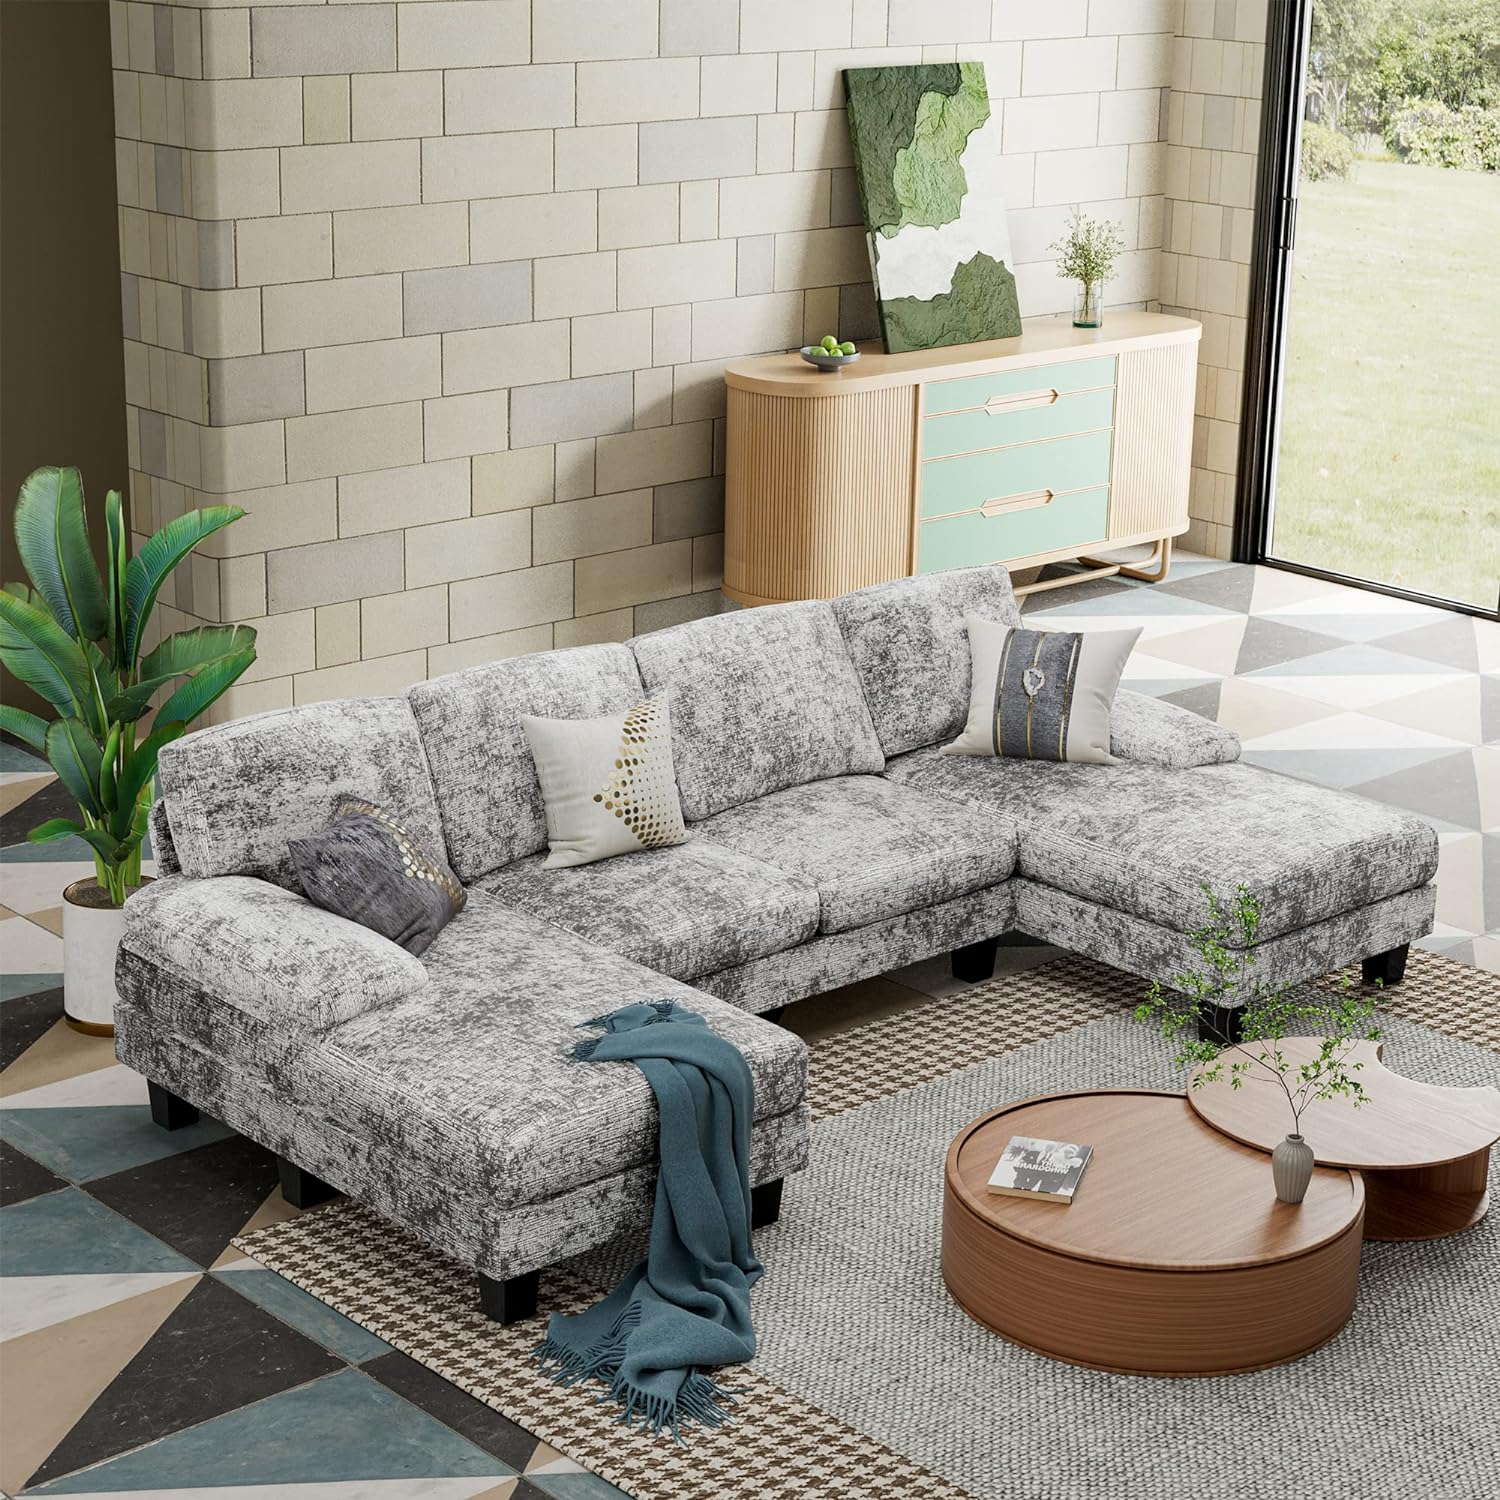

['Contemporary']


In [83]:
# 전체 사진에서 추출
with Image.open(path) as img:
    display(img)
big_predict = model.predict(big_processing)
big_style = le.inverse_transform(big_predict)
print(big_style)

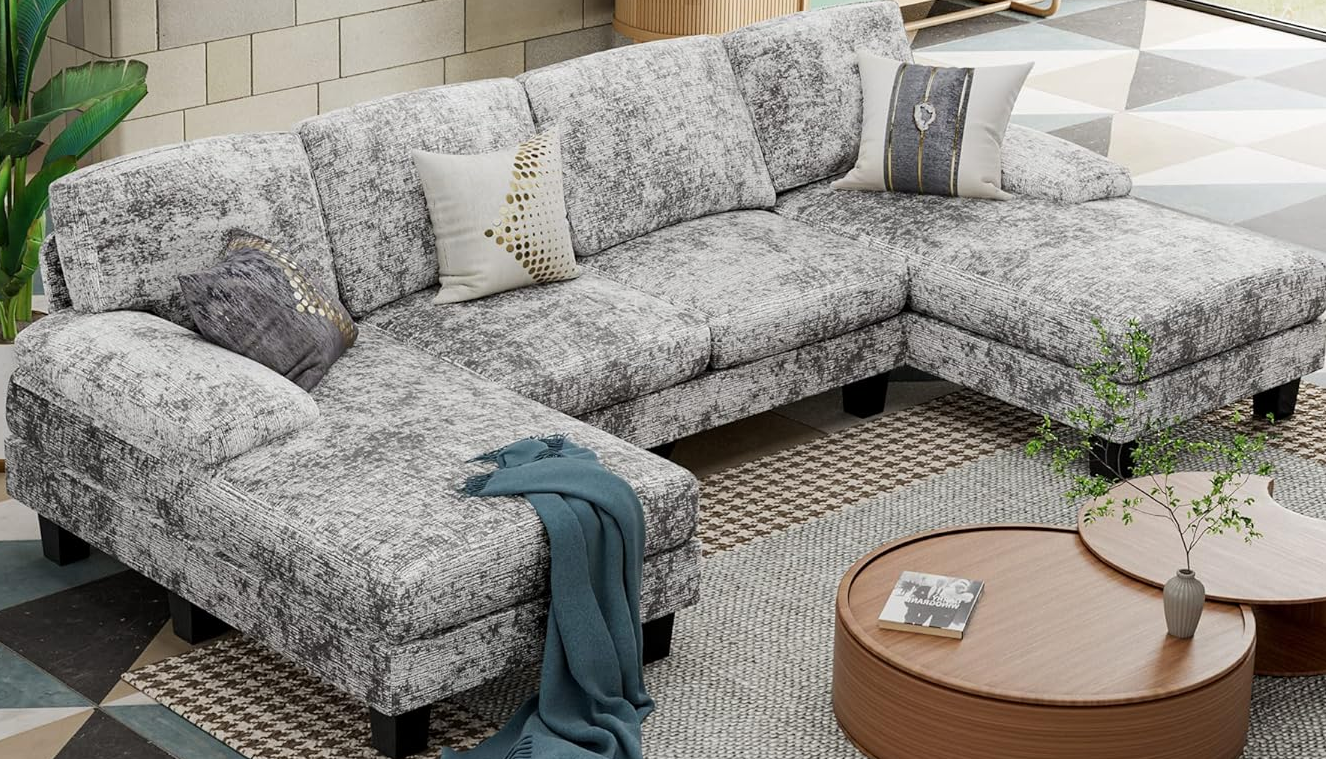

[0]
['Classic']


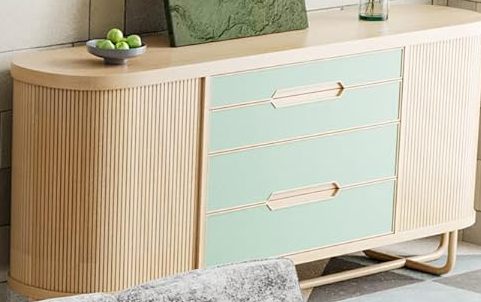

[3]
['Modern']


In [84]:
# 크롭별 스타일 추출 ['modern', 'contemporary', 'classic', 'urban', 'country', 'unique', 'minimalism']
for obj in crop_img['objects']:
    display(obj['crop_img'])
    crop_processing = process_image_file(obj['crop_img'])
    crop_predict = model.predict(crop_processing)
    print(crop_predict)
    crop_style = le.inverse_transform(crop_predict)
    print(crop_style)